Each code cell contains in line commenting aas well a text cell above to outline any key things to note about the purpose and operation of the code cells. Please follow the instrcutions in the text cells to run the solution and use in-line comments for further clarification on where to amend any variables


---



This cell imports all of the libraries used throughout the solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

This cell is used to set up the the grid that will be used. For clarity the grid is formed within the class createGrid with a series of get and set methods for the important features that will be required later on.

---

Amend the variable `grid_shape` to amend the dimensions of the grid.

Amend the variable `reward_locations` to add or change the reward location, these should be in the form `([x, y], reward)` where `[x, y]` are the coordinates for the reward location and reward is the reward given for reaching that location.

Amend the variable `actions` to 8 to include the ability to move North East, South East, South West and North West, or set to 4 to include just North, East, South, West movements.

In [2]:
# Amend this variable to amend the size of the grid
grid_shape = (20, 20)

# Edit this variable to amend the reward locations
#reward_locations =  [([6, 5], 1), ([3, 3], 6), ([8, 8], 11), ([14, 14], 16)]
reward_locations =  [([6, 5], 1)]


# Set to 4 for North, East, South, West, 8 to include NE, SE, SW, NW
actions = 8

class createGrid:
    def __init__(self):
        self.grid = np.zeros(grid_shape)
        self.rewards = reward_locations
        # Variable to define the charging point/reward location
        self.finish_positions =  np.array([x[0] for x in reward_locations])
        self.actions = actions

    # Edit start_pos to a position if you wish to choose the start location
    def get_rand_start_pos(self):
        start_pos = (
            [np.random.randint(self.get_grid_shape()[0]), 
            np.random.randint(self.get_grid_shape()[1])]
        )
        return start_pos

    # Returns true if the position is a finish position, false otherwise
    def is_finish_position(self, position):
        for current in self.finish_positions:
            current = np.array(current)
            if(np.array_equal(current, position)):
                return True
        return False

    # Returns the shape of the grid
    def get_grid_shape(self):
        return self.grid.shape

    # Returns the size of the grid
    def get_grid_size(self):
        max_x, max_y = self.get_grid_shape()
        return max_x * max_y

    # Returns the number of possible actions
    def get_no_actions(self):
        return self.actions;


    # Does the action parsed and returns the new position
    def move_to_new_pos(self, current_pos, action):
        new_pos = np.array([0,0])
        action_row_change = np.array([-1, 0, +1, 0])               #number of cell shifted in vertical as a function of the action
        action_col_change = np.array([0, +1, 0, -1])    
        if(action < 4):
            new_pos[0] = current_pos[0] + action_row_change[action]
            new_pos[1] = current_pos[1] + action_col_change[action]
        elif(action == 4):
            # Move North East
            new_pos = ([(current_pos[0] + 1), (current_pos[1] + 1)])
        elif(action == 5):
            # Move South East
            new_pos = ([(current_pos[0] + 1), (current_pos[1] - 1)])
        elif(action == 6):
            # Move South West
            new_pos = ([(current_pos[0] - 1), (current_pos[1] - 1)])
        elif(action == 7):
            # Move North West
            new_pos = ([(current_pos[0] - 1), (current_pos[1] + 1)])

        return new_pos

    # Returns the reward for being in the current position
    # Returns negative reward if the robot moves outside of the grid
    def get_reward_after_action(self, new_position):
        x, y = new_position[0], new_position[1]
        if(x > self.get_grid_shape()[0]):
            return -1
        if(y > self.get_grid_shape()[1]):
            return -1
        if (x < 0 or y < 0):
            return - 1
        
        # Check if the current state is a reward state, if so return the reward
        for current in self.rewards:
            reward_pos, actual_reward = np.array(current[0]), current[1]
            if(np.array_equal(reward_pos, new_position)):
                return actual_reward
        return 0



This cell contains the main implementation of SARSA. The environment is defined by creating an instances of the `createGrid` class. 

The final solution makes uses of eligibility traces with SARSA(λ), Ɛ-greedy and negative rewards to try and improve learning.

In [3]:
def SARSA(n_episodes, n_steps, learning_rate, epsilon, gamma, lambdas):
    # Definition of the environment
    the_grid = createGrid()
    N, M =  the_grid.get_grid_shape()
    N_states = N * M                    #total number of states
    states_matrix = np.eye(N_states)

    # See the definition of actions in cell above for operational detail
    N_actions = the_grid.get_no_actions()
    
    # Rewards
    Rewards = np.zeros((1,n_episodes))

    weights = np.random.rand(N_actions,N_states)
    learning_curve = np.zeros((1,n_episodes))


    for episode in range(n_episodes):

        # Initialization

        # Get random start position
        Start = np.array(the_grid.get_rand_start_pos())
        s_start = np.ravel_multi_index(Start,dims=(N,M),order='F')      #conversion in single index
        
        # Assign current state
        state = Start                                                   
        s_index = s_start    
       
        steps_used = 0
        q_value = 0
        reward = 0

        input_old = np.zeros((N_states,1))
        output_old = np.zeros((N_actions,1))
        Q_old = 0
        r_old = 0

        eligibility_trace = np.zeros((N_actions, 1))
                
        # Start steps
        while not(the_grid.is_finish_position(state)) and steps_used <= n_steps:
            steps_used += 1

            # Convert current state into input vector
            input_vector = states_matrix[:, s_index].reshape(N_states, 1)        

            # compute Qvalues. Qvalue=logsig(weights*input). Qvalue is 2x1, one value for each output neuron
            Q = 1 / ( 1 + np.exp( - weights.dot(input_vector)))    #Qvalue is 2x1 implementation of logsig
            
            # eps-greedy policy implementation
            greedy = (np.random.rand() > epsilon)
            if greedy:
                # Pick the best action
                action = np.argmax(Q)                           
            else:
                # Pick a random action
                action = np.random.randint(N_actions)          

            # move into a new state
            state_new = the_grid.move_to_new_pos(state, action)

            #put the robot back in grid if it goes out. Consider also the option to give a negative reward
            if state_new[0] < 0:
                state_new[0] = 0
            if state_new[0] >= N:
                state_new[0] = N - 1
            if state_new[1] < 0:
                state_new[1] = 0
            if state_new[1] >= M:
                state_new[1] = M - 1

            if(steps_used > 1):
                reward = the_grid.get_reward_after_action(state_new)
                # Update Q-value
                Q[action] = Q_old + (learning_rate * (reward + (gamma * Q[action]) - Q_old))



            #store variables for sarsa computation in the next step
            output = np.zeros((N_actions, 1))
            output[action] = 1

            # Update Weights
            q_value_ = Q[action]
            d_w = learning_rate * (reward - (q_value - (gamma * q_value_))) *  output_old.dot(input_old.T)
            eligibility_trace[action] = (reward - (q_value - (gamma * q_value_)))
            weights += d_w


            # update the elibility trace
            eligibility_trace[action] += 1   
            eligibility_trace = eligibility_trace * (lambdas * gamma)
            Q += ( (learning_rate * ((gamma * Q[action]) - Q_old)) * eligibility_trace )

            s_index_new = np.ravel_multi_index(state_new, dims=(N, M), order='F')  #conversion in a single index

            #update variables
            input_old = input_vector
            output_old = output
            Q_old = Q[action]
            r_old = reward

            state[0] = state_new[0]
            state[1] = state_new[1]
            s_index = s_index_new
            q_value = q_value_

            # Update weights for finishing state
            if (the_grid.is_finish_position(state_new)):
                dw = learning_rate * (r_old - Q_old) * output_old.dot(input_old.T)
                weights += dw

            Rewards[0, episode] = r_old
            learning_curve[0, episode] = steps_used

    return (Rewards, learning_curve)


This cell is used to setup each run of the solution. A series of parameters to be used when running SARSA are defined and then for each set of arguments, the solution is run and the results stored. The variables are stored as arrays to allow for multiple tests to be run at the same time.

---


Amend the array `learningRates` to change the learning reate that will be used during each run of the solution.

Amend the array `epsilon` to change the value of epsilon to be used during each run of the solution.

Amend the array `gamma` to change the value of gamma to be used during each run of the solution.

Amend the value of `lambdas` to change the value of lambda used in the implementation of SARSA(λ)

---

Not the length of the arrays must all be the same and the same index of each array will be used during each iteration, i.e. the first complete run of the solution will use `learningRates[0]`, `epsilon[0]`, `gamma[0]`, etc.

---

A control run of the algorithm is run with constant parameters selected by using index 0 of each of the input arrays.

In [4]:
# Parameter setup
nrepetitions = 300;  # number of runs for the algorithm
nEpisodes = 25;     # should be integer >0
nSteps = math.ceil((grid_shape[0] * grid_shape[1]) ** 1.5);        # maximum number of allowed steps
learningRate = [0.2, 0.4, 0.6, 0.8]; # should be real, Greater than 0
epsilon = [0.4, 0.1, 0.01, 0.7];     # should be real, Greater or Equal to 0; epsion=0 Greedy, otherwise epsilon-Greedy
gamma = [0.45, 0.9, 0.1, 0.01];        # should be real, positive, smaller than 1
lambdas = 0.9 # Should be an integer 0 < lambda < 1

# Matrices to store rewards/steps used. each row contains rewards obtained in one episode
totalRewards = np.zeros((nrepetitions, nEpisodes))
steps_used = np.zeros((nrepetitions, nEpisodes))

# Variables for storting results over multiple tests
learning_rewards = []
learning_steps = []
epsilon_rewards = []
epsilon_steps = []
gamma_rewards = []
gamma_steps = []

# Start iterations over episodes varying the learning rate
for i in range(len(learningRate)):
    for j in range(nrepetitions):
        totalRewards[j,:], steps_used[j,:] = SARSA(nEpisodes, nSteps, learningRate[i], epsilon[0], gamma[0], lambdas)
    learning_rewards.append(totalRewards)
    learning_steps.append(steps_used)
    totalRewards = np.zeros((nrepetitions, nEpisodes))
    steps_used = np.zeros((nrepetitions, nEpisodes)) 

# Start iterations over episodes varying the value of epsilon
for i in range(len(epsilon)):
    for j in range(nrepetitions):
        totalRewards[j,:], steps_used[j,:] = SARSA(nEpisodes, nSteps, learningRate[0], epsilon[i], gamma[0], lambdas)
    epsilon_rewards.append(totalRewards)
    epsilon_steps.append(steps_used)
    totalRewards = np.zeros((nrepetitions, nEpisodes))
    steps_used = np.zeros((nrepetitions, nEpisodes)) 

# Start iterations over episodes varying the discount factor (gamma)
for i in range(len(gamma)):
    for j in range(nrepetitions):
        totalRewards[j,:], steps_used[j,:] = SARSA(nEpisodes, nSteps, learningRate[0], epsilon[0], gamma[i], lambdas)
    gamma_rewards.append(totalRewards)
    gamma_steps.append(steps_used)
    totalRewards = np.zeros((nrepetitions, nEpisodes))
    steps_used = np.zeros((nrepetitions, nEpisodes)) 

# Run one trial with constant variables, defined by index 0 of each input array
for j in range(nrepetitions):
    totalRewards[j,:], steps_used[j,:] = SARSA(nEpisodes, nSteps, learningRate[0], epsilon[0], gamma[0], lambdas)



This cell is used to plot the average reward vs. the number of epsiodes for the first run of the solution.

---

Please amend the boundaries of the y axes based on what is being plot i.e. if a single reward location with reward of 1 is being used, then the maximum bound should be ~1.1, if multiple reward locations with different rewards are used, amend the upper boundary on line 13 to be the highest reward value +0.1..

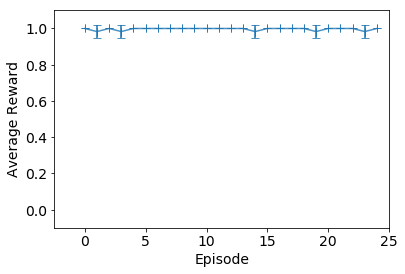

In [5]:
fontSize = 14

plt.figure()
means = np.mean(totalRewards, axis = 0)
errors = 2 * np.std(totalRewards, axis = 0) / np.sqrt(nrepetitions) # errorbars are equal to twice standard error i.e. std/sqrt(samples)


plt.errorbar(np.arange(nEpisodes), means, errors, 0, elinewidth = 2, capsize = 4, alpha =0.8)
plt.xlabel('Episode',fontsize = fontSize)
plt.ylabel('Average Reward',fontsize = fontSize)
plt.axis((-(nEpisodes/10.0), nEpisodes, -0.1, 1.1))
plt.tick_params(axis = 'both', which='major', labelsize = 14)
plt.show()

This cell is used to plot the the average number of steps taken vs. the number of episodes iterated over for the first run of the solution.

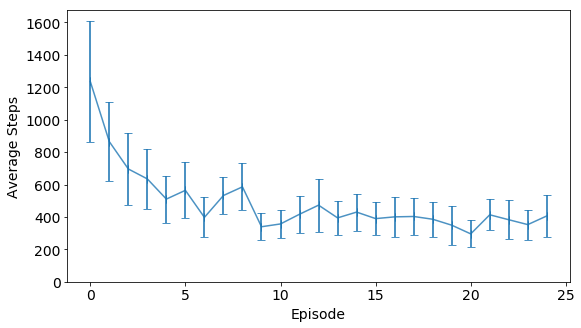

In [13]:
fig, ((ax2)) = plt.subplots(1, 1, figsize=(9,5))

ax2_means = np.mean(steps_used, axis = 0)
ax2_errors = 2 * np.std(steps_used, axis = 0) / np.sqrt(nrepetitions) # errorbars are equal to twice standard error i.e. std/sqrt(samples)

ax2.errorbar(np.arange(nEpisodes), ax2_means, ax2_errors, 0, elinewidth = 2, capsize = 4, alpha = 0.8)
ax2.set_xlabel('Episode',fontsize = fontSize)
ax2.set_ylabel('Average Steps',fontsize = fontSize)
ax2.set_ylim(ymin=0)
ax2.tick_params(axis = 'both', which='major', labelsize = 14)

plt.show() 

The below cell defined a function used to plot the test results. The function accepts 5 parameters.

`data` - The data to be used for the plot

`title` - The title of the plot

`label` - The label(s) for the line

`label_data` - The value to be attached to each label

`index` - A unique integer that corresponds to the plot

---

Line 26 and 27 could also be amended to alter the labels given to the x and y axes should something else be required as labels.

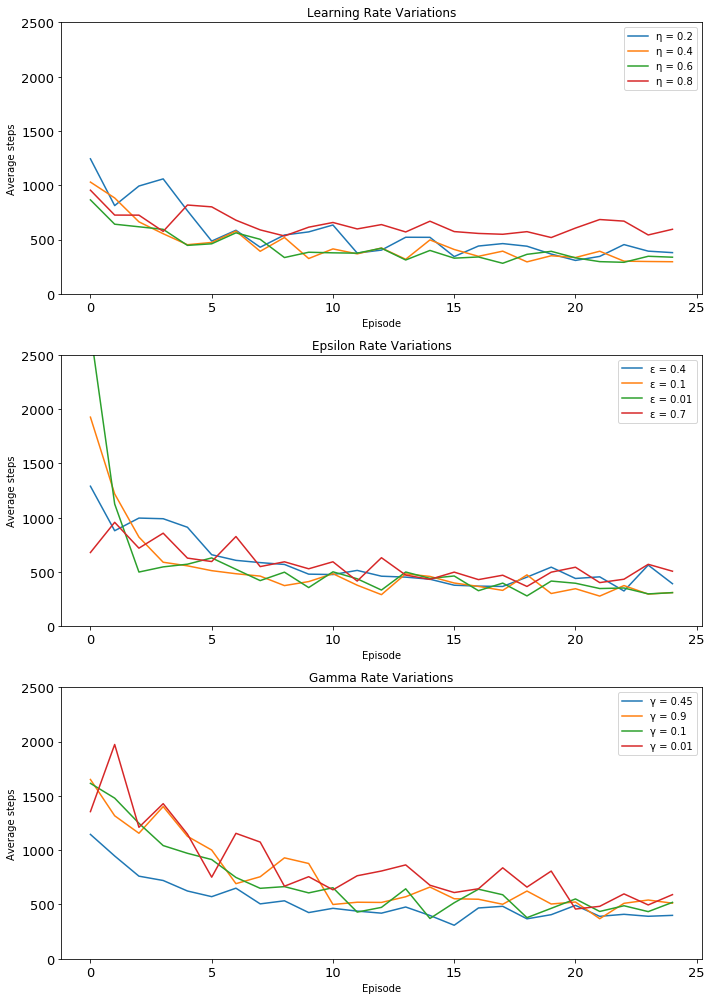

In [10]:
###
### Plotting different parameter values
###

fig = plt.subplots(3, 1, figsize=(10,14))

def plot_results(data, title, label, label_data, index):
    ax = plt.subplot(3,1, index)
    for idx in range(len(label_data)):
        step = data[idx]
        means = np.mean(step, axis=0)
        errors = 2 * np.std(step, axis=0) / np.sqrt(nrepetitions)

        line_label = label + " = {}".format(str(label_data[idx]))

        ax.plot(means, label = line_label)
        ax.set_xlabel('Episode')
        ax.set_ylabel('Average steps')
        #ax.set_ylim(ymin = 0, ymax = (max(means) * 1.2))
        ## MAY NEED TO SET YMAX VALUE FOR GRAPH TO DISPLAY PROPERLY
        ax.set_ylim(ymin = 0, ymax = 2500)
        ax.legend()
        ax.set_title(title)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 13)

    return ax

plot1 = plot_results(data = learning_steps, title = "Learning Rate Variations", label='η', label_data = learningRate, index = 1)
plot2 = plot_results(data = epsilon_steps, title = "Epsilon Rate Variations", label='ε', label_data = epsilon, index = 2)
plot3 = plot_results(data = gamma_steps, title="Gamma Rate Variations", label='γ', label_data = gamma, index = 3)
plt.tight_layout()
plt.show()


This cell above is used to to plot the results obtained from running the cells above. `plot1` shows the affects of varying the learning rate, `plot2` shows the affect of varying the value of epsilon and `plot3` shows the affect of varying the discount factor (γ) over various trials. For each set of tests all parameters remained constant whilst one of the variables was varies. 